<a href="https://colab.research.google.com/github/shafkat2/machine_learning/blob/master/RNN_with_fuel_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from google.colab import drive
drive.mount('/content/drive/')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-01-31 10:09:12--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.7.169.168, 52.4.75.11, 52.71.139.107, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.7.169.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]   5.11M  21.2MB/s    in 0.2s    

2019-01-31 10:09:13 (21.2 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://c3739c8a.ngrok.io


***Imports***

In [0]:

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
!pip install xlrd
from scipy import signal
import random
from scipy.interpolate import interp1d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,RepeatVector,TimeDistributed
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,GRU
from sklearn.metrics import mean_squared_error
import math
import time as time
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from keras.models import model_from_json
import pywt
from statsmodels.robust import mad
from sklearn.neighbors import kneighbors_graph
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [0]:
#!ls "/content/drive/My Drive/Machine_Learning/CSE499VTS/"\
#!ls "/content/drive/My Drive/CSE499.A"

***Data Preprocessing Part1***

In [0]:
df = pd.read_excel('/content/drive/My Drive/Machine_Learning/CSE499VTS/data_test_2.xlsx',sheet_name = "Device Log Data",index = False)
dt = pd.read_excel('/content/drive/My Drive/Machine_Learning/CSE499VTS/data_test_3.xlsx',sheet_name = "Device Log Data",index = False)
dk = pd.read_excel('/content/drive/My Drive/Machine_Learning/CSE499VTS/third car.xlsx',sheet_name = "Device Log Data",index = False)
#dd = pd.read_csv('/content/drive/My Drive/Machine_Learning/CSE499VTS/S_GolayFiltered.csv')
print(dk.shape)


(15718, 22)


In [0]:
# dv1 = df[['Voltage']]#.astype(float)
# dv2 = dt[['Voltage']]#.astype(float)
# dv_prime = dv1.append(dv2, ignore_index=True)
# #dd = dd[['A']].astype("float32")
# #dp.reset_index(drop=True, inplace=True)
# df_prime = dv_prime[dv_prime.Voltage > 0]
# #sns.distplot( dv_prime,bins=30)
# #dv_prime.dtypes

# plt.plot(df_prime, label="original_Data")
# plt.legend()
# df_prime.shape

In [0]:
def Zero_noise(df,X):
  
  da = df[X] == 0
 
  dm = df.copy(deep=True)
  dm[da] = None
  df = dm[X].iloc[:]
  df = pd.DataFrame(df)
  ward_list = fill_nans_scipy1(df.values)
  ward_list = pd.DataFrame(ward_list)
  plt.plot(ward_list)
  plt.savefig('/content/drive/My Drive/Machine_Learning/removing zero noise.png')
  return ward_list

def fill_nans_scipy1(padata, pkind='nearest'):
  
  aindexes = np.arange(padata.shape[0])          
  agood_indexes = np.where(np.isfinite(padata))
  b = padata[agood_indexes[0]].squeeze()
  a = agood_indexes[0] 
  f = interp1d(a
             , b
             , bounds_error=False
             , copy=False
             , fill_value="extrapolate"
             , kind=pkind)
  return f(aindexes)

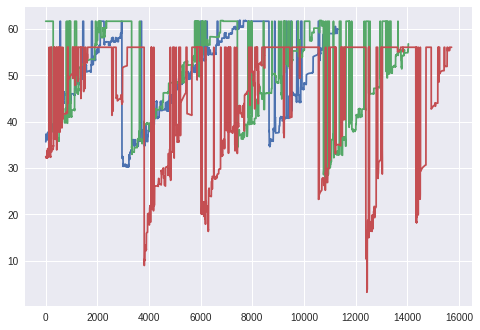

In [0]:
df = Zero_noise(df,"fuel_litre")
dt = Zero_noise(dt,"fuel_litre")
dk = Zero_noise(dk,"Fuel Information")

In [0]:
# def preprocess_signal(x):
#     return 2 * x - 1.0

# def deprocess_signal(x):
#     return (x + 1.0) / 2.0

(41081, 1)

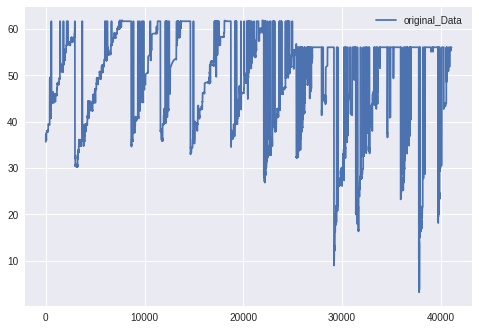

In [0]:
dp = df[[0]].astype(float)
dt = dt[[0]].astype(float)
dk = dk[[0]].astype(float)
dp = dp.append(dt, ignore_index=True)
dp = dp.append(dk,ignore_index=True)
#dd = dd[['A']].astype("float32")
#dp.reset_index(drop=True, inplace=True)


dp.dtypes

plt.plot(dp, label="original_Data")
plt.legend()
dp.shape

***Train Test Split***

In [0]:

X_train, X_test = train_test_split( dp,test_size=0,shuffle = False)

#X_train.reset_index(drop=True, inplace=True)
#X_test.reset_index(drop = True , inplace = True)

#noise_train = np.random.normal(0,5,[22423,1])
#noise_train = noise_train + X_train
noise_train = X_train
#noise_test = np.random.normal(0,10,[2218,1])
#noise_test = noise_test + X_test
noise_test =  X_test
count_row_test = X_test.shape[0]
count_row_train = X_train.shape[0]


# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
#x_scaled = min_max_scaler.fit_transform(dp)

# Run the normalizer on the dataframe
#df_normalized = pd.DataFrame(x_scaled)
X_train.shape
#plt.plot(X_train, label="Train")
#plt.legend()

(41081, 1)

In [0]:
#X_test = scipy.signal.medfilt(X_test, kernel_size=(3, 1))

In [0]:
#X_test =pd.DataFrame(X_test)  
#plt.scatter(X_test[0], X_test.index)

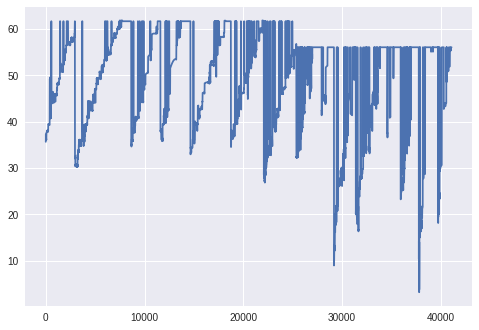

In [0]:
#dt = dp[['fuel_litre']]  

plt.plot(X_train)



In [0]:
#sns.distplot(X_test,bins=30)

***MinMaxScaler(Data Preprocessing)***

In [0]:
def  minMaxScaler(Df):
  # Create a minimum and maximum processor object
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(Df)
  df_normalized = pd.DataFrame(x_scaled)
  return df_normalized

In [0]:

def fill_nans_scipy1(padata, pkind='nearest'):
  
  aindexes = np.arange(padata.shape[0])          
  agood_indexes = np.where(np.isfinite(padata))
  b = padata[agood_indexes[0]].squeeze()
  a = agood_indexes[0] 
  f = interp1d(a
             , b
             , bounds_error=False
             , copy=False
             , fill_value="extrapolate"
             , kind=pkind)
  return f(aindexes)

In [0]:
def filter(a,window_median,polyorder,window_golay,mode,filters):
  
  X_med = []
  if(filters == "median"):
    
    for i in range(0, a.shape[0]):
        X_med.append(a.iloc[i, 0])

    X_med = medfilt(X_med,window_median)
    X_med = pd.DataFrame(X_med)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(X_med, label='After inter-polation')
    
  elif(filters == "sav"):
    
    for i in range(0, a.shape[0]):
        X_med.append(a.iloc[i, 0])
    X_med  = savgol_filter(X_med ,window_length=window_golay,polyorder= polyorder,mode = mode )
    plt.subplot(212)
    plt.plot(X_med, label='After inter-polation')
    X_med = pd.DataFrame(X_med)
    
  elif(filters == "both"):
    
    for i in range(0, a.shape[0]):
       X_med.append(a.iloc[i, 0])
        
    X_med = medfilt(X_med,window_median)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(X_med, label='After inter-polation')

    X_med  = savgol_filter(X_med ,window_length=window_golay,polyorder= polyorder,mode = mode )
    plt.subplot(212)
    plt.plot(X_med, label='After inter-polation')
    X_med = pd.DataFrame(X_med)
  
  return X_med


In [0]:
def new_feature_analysis(Volume):
  print(Volume.head())
  volume_np = [0]
  for i in range(Volume.shape[0]-1):
        volume_np.append(Volume.iloc[i+1, 0]-Volume.iloc[i, 0])

  vol = pd.DataFrame(volume_np)
  Volume = Volume.assign(volume  = vol)
  plt.figure(figsize=(18,8))
  plt.plot(Volume["volume"] , data=df, marker='', color='red', linewidth=2)
  plt.plot(Volume[0], marker='', color='black', linewidth=2, label="toto")
  return Volume


Clustering

In [0]:


def Clustering(Data,batch_size,alpha): 
  #Hiearchal CLustering
  batch_s = batch_size
  ward_list = []
  label = []
  size1 = 0
  size2 =  batch_s
  mini_batch = int(batch_size/4)              
  data = []        
  count_row_test = Data.shape[0]
  num_batches =int(round(count_row_test/ batch_s)) 
  for x in range(num_batches):
    
    batch2 = Data.iloc[size1:size2]
    size_new1 = size1
    size_new2 = size1+mini_batch
    if(batch2.std().values<alpha):
      for i in range(4):
        batch2 = Data.iloc[size_new1:size_new2]
        batch_noise = batch2.values.reshape( batch2.shape[0],1)
        #print("Compute unstructured hierarchical clustering...")
        if(batch2.shape[0]!=0):
          connectivity = kneighbors_graph(batch_noise, n_neighbors=batch2.shape[0]-1, include_self=False)
          ward = AgglomerativeClustering(n_clusters=2,connectivity=connectivity, linkage='ward').fit(batch_noise)
          ward_list.append(ward)
          data.append(batch2.values)
          label.append(ward.labels_)         
          size_new1 = size_new1+mini_batch
          size_new2 = size_new2+mini_batch
    else:
      batch_noise = batch2.values.reshape( batch2.shape[0],1)
      connectivity = kneighbors_graph(batch_noise, n_neighbors=batch2.shape[0]-1, include_self=False)
      ward = AgglomerativeClustering(n_clusters=2,connectivity=connectivity, linkage='single').fit(batch_noise)
      ward_list.append(ward)
      data.append(batch2.values)
      label.append(ward.labels_)

    #print("Elapsed time: %.2fs" % elapsed_time)
    size1 = size1+ batch_s
    size2 = size2+ batch_s

  #creating dataset
  label1 = np.concatenate(np.array( label))
  data1 =np.concatenate(np.array( data))
  db = pd.DataFrame({ 'labels':label1})
  db = db.assign(data = data1)
  print(db.shape[0])
  da = db['labels'] == 0
  dc = db['labels'] == 1


  da = db[da] #up
  dc = db[dc]

  #sns.distplot(da['data'],bins=30)
  
  #visualization
  plt.figure(1)
  plt.subplot(211) 
  plt.plot(da['data'], label='0')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()
  plt.subplot(212) 
  plt.plot(dc['data'], label='1')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()
  
  #removing noise
  da = db['labels'] == 0
  dc = db['labels'] == 1
  #dm = db.copy(deep=True)
  #dm = dm[da]
  #dm = dm.iloc[:,1]
  #x = dm.mean()
  #print(x)
  dm = db.copy(deep=True)
  dm[dc] = None
  d_test_noise = dm.iloc[:,1]
  d_test_noise = pd.DataFrame(d_test_noise)
  
  #visualization
  plt.figure(2)
  plt.subplot(211)
  plt.plot(d_test_noise, label='After Removing noise')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()
  
  #Getting Indexes for interpolation
  a = dm[dc].index.astype(int).values


  #plt.plot(d_test_noise, label='0')
  #d_test_noise = pd.DataFrame(d_test_noise)

  #d_test_noise_norm = minMaxScaler(d_test_noise)
  #sns.distplot(d_test_noise_norm,bins=30)
  #plt.plot(a, label='0')
  d_test_noise = d_test_noise.values

#   a =np.where(np.isfinite(d_test_noise))
#   a = d_test_noise[a[0]]
  
  #interpolation
  New_test_data = fill_nans_scipy1(d_test_noise)
  New_test_data = pd.DataFrame(New_test_data)
  plt.subplot(212)
  plt.figure(figsize=(18,8))
  plt.plot(New_test_data, label='After inter-polation')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()
  return New_test_data



Feature Creation

In [0]:
# New_feature =  new_feature_analysis(S)

41040


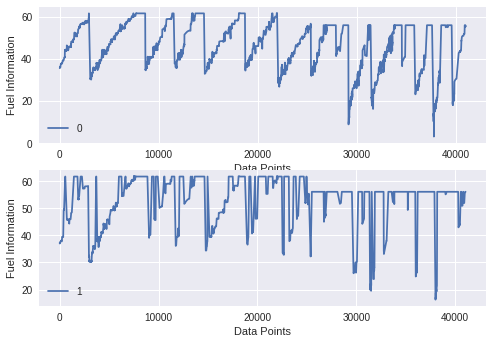

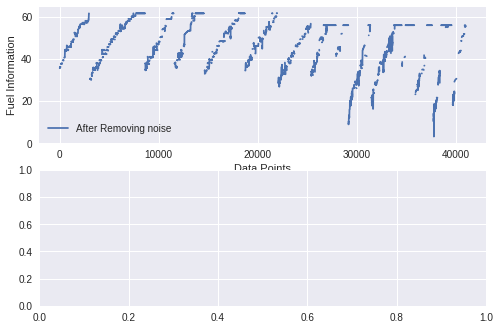

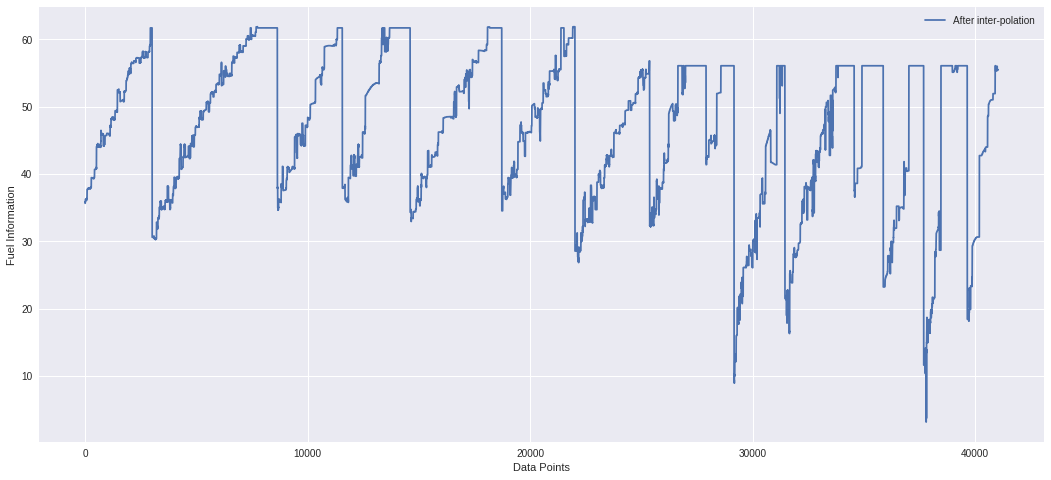

In [0]:
D = Clustering(X_train,180,2)



           0
0  35.651001
1  35.651001
2  35.651001
3  35.651001
4  35.651001


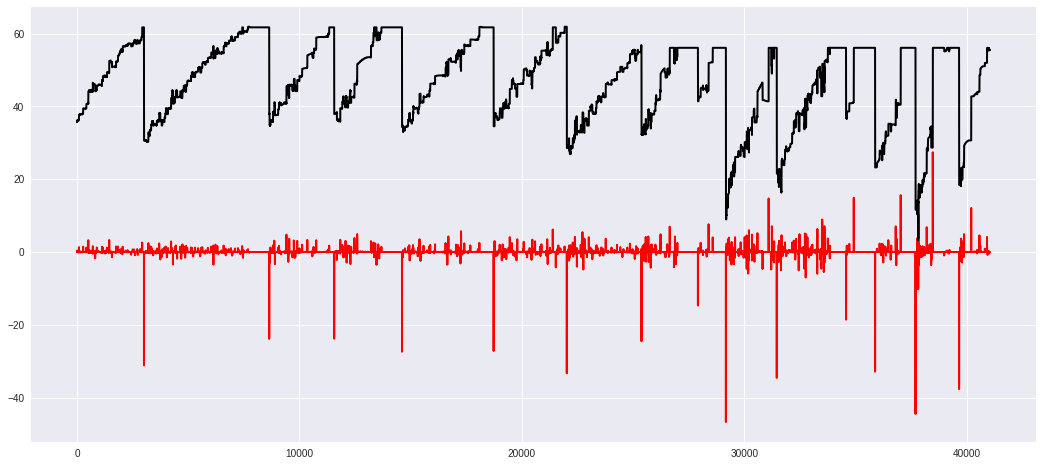

In [0]:
Volume_train =  new_feature_analysis(D)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(41040, 1)

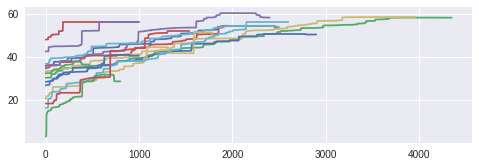

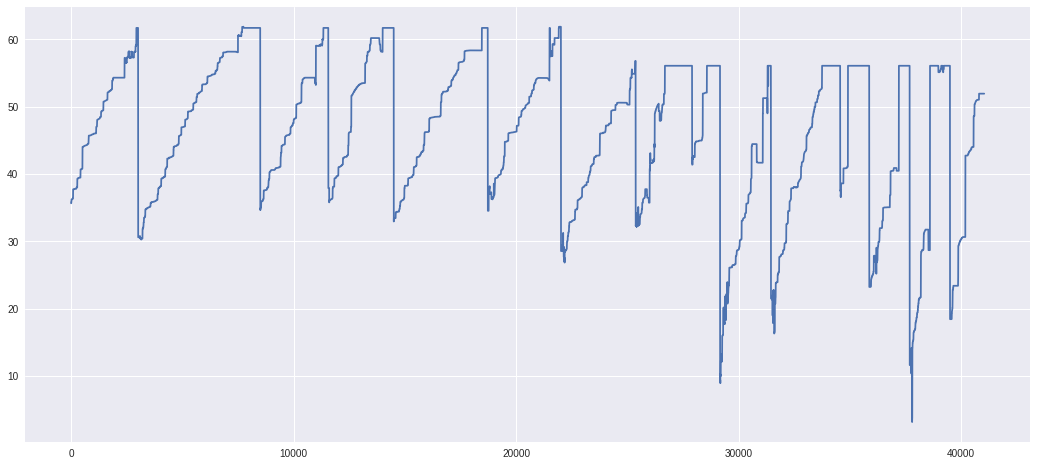

In [0]:
D_train1 = filter(D[0:2400],window_median = 1001 ,polyorder = 1,window_golay = 1001,mode = "interp",filters = "median")
D_train2 = D[2400:3150]
D_train3 = filter(D[3150:7500],window_median = 1001 ,polyorder = 1,window_golay = 1001,mode = "interp",filters = "median")
D_train4 = D[7500:8500]
D_train5 = filter(D[8500:11000],window_median = 1001 ,polyorder = 1,window_golay = 1001,mode = "interp",filters = "median")
D_train6 = D[11000:11600]
D_train7 = filter(D[11600:14000],window_median = 1001 ,polyorder = 1,window_golay = 1001,mode = "interp",filters = "median")
D_train9 = D[14000:14500]
D_train10 = filter(D[14500:18459],window_median = 1001 ,polyorder = 1,window_golay = 1001,mode = "interp",filters = "median")
D_train11 = D[18459:19000]
D_train12 = filter(D[19000:21500],window_median = 1001 ,polyorder = 1,window_golay = 1001,mode = "interp",filters = "median")
D_train13 = D[21500:22200]
D_train14 = filter(D[22200:25100],window_median = 1001 ,polyorder = 1,window_golay = 1001,mode = "interp",filters = "median")
D_train15 = D[25100:25500]
D_train16 = filter(D[25500:26001],window_median = 401 ,polyorder = 1,window_golay = 401,mode = "interp",filters = "median")
D_train17 = D[26001:26501]
D_train18 = filter(D[26501:27501],window_median = 401 ,polyorder = 1,window_golay = 401,mode = "interp",filters = "median")
D_train19 = D[27501:28001]
D_train20 = filter(D[28001:29001],window_median = 401 ,polyorder = 1,window_golay = 401,mode = "interp",filters = "median")
D_train21 = D[29001:29501]
D_train22 = filter(D[29501:31300],window_median = 401 ,polyorder = 1,window_golay = 401,mode = "interp",filters = "median")
D_train23 = D[31300:31600]
D_train24 = filter(D[31600:34201],window_median = 401 ,polyorder = 1,window_golay = 401,mode = "interp",filters = "median")
D_train25 = D[34201:36201]
D_train26 = filter(D[36201:37201],window_median = 401 ,polyorder = 1,window_golay = 501,mode = "interp",filters = "median")
D_train27 = D[37201:37800]
D_train28 = filter(D[37800:38600],window_median = 401 ,polyorder = 1,window_golay = 501,mode = "interp",filters = "median")
D_train29 = D[38600:39500]
D_train30 = filter(D[39500:41040],window_median = 401 ,polyorder = 1,window_golay = 501,mode = "interp",filters = "median")
D_list = [D_train1,D_train2,D_train3,D_train4,D_train5,D_train6,D_train7,D_train9,D_train10,D_train11,D_train12,D_train13,D_train14,D_train15,D_train16,D_train17,D_train18,D_train19,D_train20,D_train21,D_train22,D_train23,D_train24,D_train25,D_train26,D_train27,D_train28,D_train29,D_train30 ]

D_train_final = pd.DataFrame()
for x in range(len(D_list)):
  
  D_train_final = D_train_final.append(D_list[x], ignore_index=True)
plt.figure(figsize=(18,8))
plt.plot(D_train_final)
D_train_final.shape

In [0]:
#D_train_final =  new_feature_analysis(D_train_final)

In [0]:
D2 = minMaxScaler(Volume_train)
D3 = minMaxScaler(D_train_final)

***Data Preprocessing Part 2***

In [0]:
def data_preprocessing_train(train,test,timestamp,feature,parallel_processing):
  
  X_train =[]
  y_fet1 = []
  y_test = []
  

  
  for i in range(timestamp,test.shape[0]-parallel_processing):
     y_fet1.append(train.iloc[i-timestamp:i,0:2].values)  
     y_test.append(test.iloc[i-timestamp,0])    
  y_fet1 ,y_test = np.array(y_fet1),np.array(y_test)
  X_train = np.reshape(y_fet1, (y_fet1.shape[0], y_fet1.shape[1], feature))
  print(X_train.shape)
  print(y_test.shape)
  return  X_train,y_test

def data_preprocessing_train_autoencoder(train,test,timestamp,feature,parallel_processing):
  
  X_train =[]
  y_fet1 = []
  y_test = []
  

  
  for i in range(timestamp,test.shape[0]-parallel_processing):
     y_fet1.append(train.iloc[i-timestamp:i,0:2].values)  
     y_test.append(test.iloc[i-timestamp:i,0:1].values)    
  y_fet1 ,y_test = np.array(y_fet1),np.array(y_test)
  X_train = np.reshape(y_fet1, (y_fet1.shape[0], y_fet1.shape[1], feature))
  y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
  print(X_train.shape)
  print(y_test.shape)
  return  X_train,y_test

def data_preprocessing_predict(data1,timestamp,feature):
  y_fet1 = []
  inputs = []
  for i in range(timestamp,data1.shape[0]-57):
     y_fet1.append(data1.iloc[i-timestamp:i,0:2].values) 
  y_fet1   = np.array(y_fet1)
  inputs = np.reshape(y_fet1, (y_fet1.shape[0], y_fet1.shape[1], feature))
  print(inputs.shape)
  return  inputs


In [0]:
def LSTM_Fit_denoise(X_tobe_trained,y_tobe_predicted,nb_epoch,batch_size,timestamp,data_size):
  

  regressor = Sequential()
  regressor.add(LSTM(units = 60,return_sequences=True, batch_input_shape = (batch_size,timestamp ,X_tobe_trained.shape[2])))
  regressor.add(Bidirectional(LSTM(30,activation='tanh',recurrent_dropout= 0.4)))
  regressor.add(RepeatVector(timestamp))
  regressor.add(Bidirectional(LSTM(30,return_sequences=True,recurrent_dropout= 0.4)))
  regressor.add(LSTM(60,return_sequences=True))
  regressor.add(TimeDistributed(Dense(units = 1,activation='tanh')))

  
  regressor.compile(optimizer =tf.train.RMSPropOptimizer(learning_rate=0.001),loss = "mean_squared_error")
  
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.logging.set_verbosity(tf.logging.INFO)
  regressor = tf.contrib.tpu.keras_to_tpu_model(regressor,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
  tbCallBack = TensorBoard(log_dir='./log',
                         write_graph=True,
                         write_grads=True,
                         batch_size=data_size)
  
#   for i in range(nb_epoch):
#     print("epoch: ",i)
#     x = 0
#     y = data_size
#     for d in range(int(len(X_tobe_trained)/data_size)):
      
  regressor.fit(X_tobe_trained,y_tobe_predicted,epochs=nb_epoch,batch_size = batch_size ,shuffle = False,callbacks=[tbCallBack])
      #test_rmse.append(evaluate(regressor, test_tobe_predicted_unscaled ,test_tobe_predicted_scaled,Test_non_scaled_predict,batch_size))
#       y = y + data_size
#       x = x + data_size
      #history = pd.DataFrame()
      #history['test'] = test_rmse 

  return regressor

In [0]:
def evaluate(model,non_scaled_test,scaled_test,tobe_predicted,batch_size):
   
  min_max_scaler.fit(non_scaled_test)

  predict = model.predict(scaled_test,batch_size)
  predict1 = min_max_scaler.inverse_transform(predict)
  rmse = math.sqrt(mean_squared_error(tobe_predicted[0:], predict1[0:]))
  return rmse

In [0]:
def predict(model,non_scaled_pre,scaled_pre,batch_size):
  
  min_max_scaler.fit(non_scaled_pre)
  

  predict = model.predict(scaled_pre,batch_size)
  predict1 = min_max_scaler.inverse_transform(predict)
  plt.figure(1)
  plt.subplot(211)
  plt.plot(non_scaled_pre, label='Noisy')
  plt.subplot(212)
  plt.plot(predict1, label='Denoised')
  plt.xlabel("datapoints")
  plt.ylabel("Fuel Information")
  plt.legend()
  predict1 = pd.DataFrame( predict1)
  return predict1
  
  

In [0]:
def model_loss_accuracy(model,epoch,timestamp,recurrent):
  # summarize history for loss
  plt.plot(model.history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')


In [0]:
# Train,Label = data_preprocessing_train(D2,D3,60,2)



In [0]:
# Test_non_scaled = S[0:4800]
# Test_non_scaled_predict = S_test_final
# Test_scaled = data_preprocessing_predict(minMaxScaler(New_feature),60,2)


In [0]:
# def making_train_test_for_ml(Train_set,Correct_train_set,features,Test_non_scaled_first_column,Test_non_scaled_predict1,Test_scaled_for_prediction):
#   Train,Label = data_preprocessing_train(Train_set,Correct_train_set,72,features)
#   Test_non_scaled = Test_non_scaled_first_column
#   Test_non_scaled_predict = Test_non_scaled_predict1
#   Test_scaled = data_preprocessing_predict(minMaxScaler(Test_scaled_for_prediction),72,features)
  
#   return  Train,Label,Test_non_scaled,Test_non_scaled_predict,Test_scaled 

In [0]:
# Train,Label,Test_non_scaled,Test_non_scaled_predict,Test_scaled = making_train_test_for_ml(D2,D3,2,S[0:4800],S_test_final,New_feature)


In [0]:
def making_train_test_for_ml(Train_set,Correct_train_set,timestamp,features,parallel_processing):
  Train,Label = data_preprocessing_train_autoencoder(Train_set,Correct_train_set,timestamp,features,parallel_processing)

  
  return  Train,Label

In [0]:
Train,Label = making_train_test_for_ml(D2,D3,60,2,84)

(40896, 60, 2)
(40896, 60, 1)


In [0]:

n_batch = 96*8
n_epochs =200
timestamp = 60
#for i in range(repeats):
model = LSTM_Fit_denoise( Train, Label, n_epochs, n_batch,timestamp,96)
		#pyplot.plot(history['train'], color='blue')
#plt.plot(history['test'], color='orange')
		#print('%d), TestRMSE=%f' % (i, history['test'].iloc[-1]))
#plt.savefig('/content/drive/My Drive/Machine_Learning/CSE499VTS/epochs_diagnostic.png')

  

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.88.201.250:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10331057041611189176)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5799056560132299252)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 17794489351421070431)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6177060693399855640)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 8867367928484464865)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
def make_model(timestamp):
  regressor = Sequential()
  regressor.add(LSTM(units = 60,return_sequences=True, input_shape = (None,2),))
  regressor.add(Bidirectional(LSTM(15,activation='tanh',recurrent_dropout= 0.2)))
  regressor.add(RepeatVector(timestamp))
  regressor.add(Bidirectional(LSTM(15,return_sequences=True,recurrent_dropout= 0.2)))
  regressor.add(LSTM(60,return_sequences=True))
  regressor.add(TimeDistributed(Dense(units = 1,activation='tanh')))


  
  regressor.compile(optimizer =tf.train.RMSPropOptimizer(learning_rate=0.007),loss = "mean_squared_error")
  
  return regressor

In [0]:
#model_loss_accuracy(model,n_epochs,timestamp,0.2)

In [0]:
model.save_weights("/content/drive/My Drive/Machine_Learning/CSE499VTS/tpu_model_denoise_Whole_batch_LSTM_autoencoder.h5",overwrite = True)


INFO:tensorflow:Copying TPU weights to the CPU


In [0]:
inferencing_model = make_model(timestamp = 60)
inferencing_model.load_weights('/content/drive/My Drive/Machine_Learning/CSE499VTS/tpu_model_denoise_Whole_batch_LSTM_autoencoder.h5')
inferencing_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 60)          15120     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60)                21840     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 60, 60)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 60)            21840     
_________________________________________________________________
lstm_11 (LSTM)               (None, 60, 60)            29040     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 1)             61        
Total params: 87,901
Trainable params: 87,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
def pre_data_for_predict(to_predict,timstamp,features):
  predict = data_preprocessing_predict(minMaxScaler(to_predict),timstamp,features)
  return  predict
  
  



In [0]:
prediction = pre_data_for_predict(Volume_train,60,2)
Test_scaled  = D_train_final


In [0]:
neural = predict(inferencing_model,Test_scaled,prediction,72)
#neural = pd.DataFrame(neural)
neural.size

In [0]:

def denoise(data,wavelet,levels,level,alpha):
    WC = pywt.wavedec(data,wavelet,mode = "per",level = level)
    noiseSigma = mad( WC[-levels] )
    threshold=alpha*noiseSigma*math.sqrt(math.log2(data.size))
    NWC = map(lambda x: pywt.threshold(x,threshold,'garotte'), WC)
    NWC = list(NWC)
    NWC = pywt.waverec( NWC, wavelet,mode= "per")
    plt.plot(NWC)
    NWC = pd.DataFrame(NWC)
    return NWC

In [0]:

def thresholding_algo_RF(y, lag, threshold_for_refill, influence):
    signals = np.zeros(len(y))
    Signal_RF = []
    Index_start_RF = []
    Index_stop_RF = []
    volume_RF = []
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold_for_refill:
            if y[i] < avgFilter[i-1]:
                signals[i] = -1
                Signal_RF.append("refill")
                Index_start_RF.append(i)
                Index_stop_RF.append(i-1)
                volume_RF.append(y[i])  

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
      
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
        

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter)),dict(signals = Signal_RF,
                                                        Index_start = Index_start_RF,
                                                          Index_stop = Index_stop_RF,
                                                         volume = volume_RF )

In [0]:
def thresholding_algo_ST(y, lag,threshold_for_steal, influence):
    signals = np.zeros(len(y))
    Signal_ST = []
    Index_start_ST = []
    Index_stop_ST = []
    volume_ST = []
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold_for_steal:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
                Signal_ST.append("stolen")
                Index_start_ST.append(i)
                Index_stop_ST.append(i-1)
                volume_ST.append(y[i])  

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
      
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
        

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter)),dict(signals = Signal_ST,
                                                        Index_start = Index_start_ST,
                                                          Index_stop = Index_stop_ST,
                                                         volume = volume_ST )

In [0]:
def wavlet_analysis(Data,batch_size,levels,level,alpha): 
  #wavelet analysis
  batch_s = batch_size
  ward_list = pd.DataFrame()
  size1 = 0
  size2 =  batch_s     
  count_row_test = Data.shape[0]
  num_batches =int(round(count_row_test/ batch_s)) 
  for x in range(num_batches):
    
    batch2 = Data.iloc[size1:size2]
    batch_noise = batch2.values.squeeze()
    ward = denoise(batch_noise,"haar",levels,level,alpha)
    ward_list = ward_list.append(ward,ignore_index=True)
    size1 = size1+ batch_s
    size2 = size2+ batch_s
  
  ward_list = ward_list.values
  
  #interpolation
  ward_list = fill_nans_scipy1(ward_list)
  ward_list = pd.DataFrame(ward_list)
  return ward_list

In [0]:
def detecting_Stolen(data,lag =5,threshold1 = 2,influence = 0):
  result,Stolen = thresholding_algo_ST(data, lag=lag,threshold_for_steal = threshold1, influence=influence)
  plt.subplot(211)
  plt.plot(np.arange(1, len(data)+1),data)
  plt.subplot(212)
  plt.step(np.arange(1, len(data)+1), result["signals"], color="pink", lw=2)
  plt.ylim(-1.5, 1.5)
  print(Stolen)
  return Stolen

In [0]:

def detecting_Refill(data,lag =5,threshold1 = 1.2,influence = 0):
  result,Refill = thresholding_algo_RF(data, lag=lag, threshold_for_refill=threshold1,influence=influence)
  plt.subplot(211)
  plt.plot(np.arange(1, len(data)+1),data)
  plt.subplot(212)
  plt.step(np.arange(1, len(data)+1), result["signals"], color="red", lw=2)
  plt.ylim(-1.5, 1.5)
  print(Refill)
  return Refill

In [0]:
 neural1 =  wavlet_analysis(neural,100,6,10,3.5)

In [0]:
plt.plot(neural1)

In [0]:
volume1 =  new_feature_analysis(neural1)


In [0]:
stolen = detecting_Stolen(volume1["volume"],lag =5,threshold1 = 4,influence = 0)



In [0]:
refill = detecting_Refill(volume1["volume"],lag =5,threshold1 = 5,influence = 0)


In [0]:
Test_non_scaled1  = Test_non_scaled[1000:2550]
Test_non_scaled2  = Test_non_scaled[3000:3300]
Test_non_scaled3  = Test_non_scaled[4000:]
Test_list_mod = [Test_non_scaled1,Test_non_scaled2,Test_non_scaled3]
Test_train_final_mod = pd.DataFrame()
for x in range(len(Test_list_mod)):
  
  Test_train_final_mod = Test_train_final_mod.append(Test_list_mod[x], ignore_index=True)

#Test_train_final_mod = Clustering(Test_train_final_mod,200)
Test_train_final  = new_feature_analysis(Test_train_final_mod)
test_scaled =data_preprocessing_predict(minMaxScaler(Test_train_final),100,2)

test_scaled.shape

In [0]:
neural = predict(inferencing_model,Test_train_final_mod,test_scaled,72)



In [0]:
#neural = pd.DataFrame(neural)
neural = neural.squeeze()

In [0]:



neural1 =  wavlet_analysis(neural,100,6,10,3.7)

In [0]:
plt.plot(neural1)

In [0]:
volume1 =  new_feature_analysis(neural1)


In [0]:
stolen = detecting_Stolen(volume1["volume"],lag =5,threshold1 = 2.8 ,influence = 0)

In [0]:
refill = detecting_Refill(volume1["volume"],lag =5,threshold1 = 5,influence = 0)

In [0]:
#neural1 = filter(neural,window_median = 67 ,polyorder = 1,window_golay = 11 ,mode = "interp",filters = "median")
#neural1 = pd.DataFrame(neural1)

In [0]:
# model_json = model.to_json()
# with open("/content/drive/My Drive/Machine_Learning/CSE499VTS/model.json","w")as json_file:
#   json_file.write(model_json)
# model.save_weights("/content/drive/My Drive/Machine_Learning/CSE499VTS/model1.h5")
# print("model saved")

In [0]:
# json_file = open("/content/drive/My Drive/Machine_Learning/CSE499VTS/model.json",'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# loaded_model.load_weights("/content/drive/My Drive/Machine_Learning/CSE499VTS/model.h5")
# print("loaded model from disk")

In [0]:
# X_independent = Clustering_voltage(df_prime[0:19900],280)
# Y_dependent =  D

# Test_non_scaled = Clustering_voltage(df_prime[19601:],280)


# X = np.arange(0,19600,1)
# print(Label.shape)
# test_X = np.arange(0,4760,1)
# X = X.reshape(len(X),1)
# test_X = test_X.reshape(len(test_X),1)


In [0]:
# from sklearn.ensemble import RandomForestRegressor
# regress = RandomForestRegressor(n_estimators = 1000, random_state = 10,min_samples_split=200)
# regress.fit(X_independent,Y_dependent)

In [0]:
# from sklearn.linear_model import LinearRegression
# linear = LinearRegression()
# linear.fit(X_independent,Y_dependent)

In [0]:
# from sklearn.preprocessing import PolynomialFeatures
# poly_reg = PolynomialFeatures(degree = 10)
# X_poly = poly_reg.fit_transform(X_independent)
# linear_poly1 = LinearRegression()
# linear_poly1.fit(X_poly,Y_dependent)


In [0]:
# plt.figure(2)
# plt.subplot(211)
# plt.plot(X,X_independent[0],color='black')
# plt.subplot(212)
# plt.plot(X,Y_dependent[0],color='red')



In [0]:
# plt.figure(3)
# plt.subplot(311)
# plt.plot(Test_non_scaled,color='red')
# plt.subplot(312)
# plt.plot(neural,color='red')
# plt.subplot(313)
# plt.plot(regress.predict(Test_non_scaled),color='red')


In [0]:
# plt.figure(3)
# plt.subplot(311)
# plt.plot(test_X,Test_non_scaled,color='red')
# plt.subplot(312)
# plt.plot(neural,color='red')
# plt.subplot(313)
# plt.plot(test_X,regress.predict(Test_non_scaled),color = "blue")

***Inputs and outputs***

***Save model***